In [ ]:
# Init pack

import numpy as np
import numpy as np
from scipy.integrate import solve_ivp
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
import torch
import matplotlib.pyplot as plt
from torch.amp import GradScaler, autocast
from torch.nn.parallel import DataParallel

psi = np.load('/home/danielboscu/Documents/code/AI_RES/data/actual/long_run_310k.npy')

# Pre-processing

psi = psi[:,1,:]

mean_psi = np.mean(psi, axis=0, keepdims=True)
std_psi = np.std(psi, axis=0, keepdims=True)
psi = (psi - mean_psi) / std_psi

lead = 1
trainN = 250000
valN = 50000
index = 63

# Defining the variable ranges
variable_range = [(0,24), (25, 49), (50, 74), (0, 49), (0,74)]

# Select the variable: 0 for real perturbation, 1 for imaginary perturbation, 2 for zonal winds
variable = 3
num_variables = variable_range[variable][1] - variable_range[variable][0] + 1
print(num_variables)

# Shuffle and map indices
np.random.seed(42)
valid_indices = np.arange(0, trainN - lead)
shuffled_indices = np.random.permutation(valid_indices)

# Now constrain the shuffled indices to the variable range
np_psi_train_input = psi[shuffled_indices, variable_range[variable][0]:variable_range[variable][1]+1]
np_psi_train_label = psi[shuffled_indices + lead, :]

psi_train_input = torch.tensor(np_psi_train_input)
psi_train_label = torch.tensor(np_psi_train_label)

np_psi_val_input = psi[trainN:trainN+valN, variable_range[variable][0]:variable_range[variable][1]+1]
np_psi_val_label = psi[trainN+lead:trainN+valN+lead, :]
psi_val_input = torch.tensor(np_psi_val_input)
psi_val_label =  torch.tensor(np_psi_val_label)

print(psi.shape)
print(psi_train_input.shape)
print(psi_train_label.shape)
print(psi_val_input.shape)
print(psi_val_label.shape)

# Define the encoder (MLP)
class Encoder(nn.Module):
    def __init__(self, latent_dim, num_neurons):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(75, num_neurons)  # Input layer (2 + 2) -> Hidden layer (128)
        self.fc2 = nn.Linear(num_neurons, num_neurons)  # Hidden layer (128) -> Hidden layer (128)
        self.fc3 = nn.Linear(num_neurons, num_neurons)  # Hidden layer (128) -> Hidden layer (128)
        self.fc4 = nn.Linear(num_neurons, num_neurons)  # Hidden layer (128) -> Hidden layer (128)
        self.fc5 = nn.Linear(num_neurons, num_neurons)  # Hidden layer (128) -> Hidden layer (128)
        self.fc6 = nn.Linear(num_neurons, num_neurons)  # Hidden layer (128) -> Hidden layer (128)
        self.fc_mu = nn.Linear(num_neurons, latent_dim)  # Hidden layer (128) -> Latent space (2)
        self.fc_logvar = nn.Linear(num_neurons, latent_dim)  # Hidden layer (128) -> Log variance (2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Activation function for hidden layer
        x = torch.relu(self.fc2(x)) + x
        x = torch.relu(self.fc3(x)) + x
        x = torch.relu(self.fc4(x)) + x
        x = torch.relu(self.fc5(x)) + x
        x = torch.relu(self.fc6(x)) + x
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

# Define the decoder (MLP)
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim, condition_dim, num_neurons):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim + condition_dim, num_neurons)  # Input layer (2 + 2) -> Hidden layer (128)
        self.fc2 = nn.Linear(num_neurons, num_neurons)  # Hidden layer (128) -> Hidden layer (128)
        self.fc3 = nn.Linear(num_neurons, num_neurons)  # Hidden layer (128) -> Hidden layer (128)
        self.fc4 = nn.Linear(num_neurons, num_neurons)  # Hidden layer (128) -> Hidden layer (128)
        self.fc5 = nn.Linear(num_neurons, num_neurons)  # Hidden layer (128) -> Hidden layer (128)
        self.fc6 = nn.Linear(num_neurons, num_neurons)  # Hidden layer (128) -> Hidden layer (128)
        self.fc_output = nn.Linear(num_neurons, output_dim)  # Hidden layer (128) -> Output layer (2)

    def forward(self, z, condition):
        z = torch.cat((z, condition[:, :50]), dim=1)  # Concatenate latent vector and condition
        z = torch.relu(self.fc1(z))  # Activation function for hidden layer
        z = torch.relu(self.fc2(z)) + z
        z = torch.relu(self.fc3(z)) + z
        z = torch.relu(self.fc4(z)) + z
        z = torch.relu(self.fc5(z)) + z
        z = torch.relu(self.fc6(z)) + z
        output = self.fc_output(z)
        return output

# Define the VAE model
class ConditionalVAE(nn.Module):
    def __init__(self, latent_dim, output_dim, condition_dim, num_neurons):
        super(ConditionalVAE, self).__init__()
        self.encoder = Encoder(latent_dim, num_neurons)
        self.decoder = Decoder(latent_dim, output_dim, condition_dim, num_neurons)

    def encode(self, x):
        mu, logvar = self.encoder(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def decode(self, z, condition):
        return self.decoder(z, condition)

    def forward(self, x, condition):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        output = self.decode(z, condition)
        return output, mu, logvar

output_dim = 75
latent_dim = 32
condition_dim = num_variables
batch_size = 1024

In [ ]:
# CHOOSING BY EXP FIT
# TO-DO: Check if crps is correct

from scipy.stats import linregress
from plotly.subplots import make_subplots
import plotly.graph_objs as go
from scipy.stats import norm
from sklearn.decomposition import PCA
import pandas as pd
import plotly.express as px

def normalize_transition_time(s, neuro_num, r):
    """
    Normalize the transition time based on the specified num_neurons and reference value.

    Args:
        s (float): The transition time to normalize.
        neuro_num (float): The num_neurons value for normalization.
        r (float): The reference value for normalization.

    Returns:
        norm (float): The normalized transition time.
    """
    norm = 1 - np.exp(-np.abs((s - r)) / neuro_num)
    return norm

# Code from Ira Shokar but slightly changed
def crps_score(p, y):
    """
    Calculate CRPS for given predictions and observations.

    Args:
        p (Tensor): Predictions, shape (N, D) where N = ens_num and D is the dimension of the prediction.
        y (Tensor): Observations, shape (D) where D is the dimension of the observation.

    Returns:
        crps (float): The CRPS score.
    """
    y  = y.unsqueeze(0)
    # First term: mean distance from observations to ensemble members
    mae     = torch.cdist(y, p, 1).mean()
    # Second term: mean distance between ensemble members (properly normalized)
    ens_var = torch.cdist(p, p, 1).mean()
    
    return mae - 0.5 * ens_var

# Function to calculate transition durations
def calculate_transition_durations(y, u, l):
    """
    Calculate the return periods with user-defined upper and lower bounds.

    Args:
        y (np.array): The time series data.
        u (float): The upper bound for the transition.
        l (float): The lower bound for the transition.

    Returns:
        t_times (list): The list of return periods for transitions.
    """

    t_times = []
    s = None
    above_u = False
    below_l = False
    for i in range(1, len(y)):
        if y[i] < l:  
            below_l = True
            above_u = False
        elif y[i] > u:  
            if below_l and s is not None:
                t_times.append(i - s)
                s = None  
            above_u = True
            below_l = False

        if below_l and s is None:
            s = i
    return t_times

def KL_coefficient(r, p, num_neurons, cycle, KL_by_dim_cycle, L1_by_dym_cycle):
    """
    Calculate the KL divergence between two distributions and normalize it.

    Args:
        r (np.array): Real distribution.
        p (np.array): Predicted distribution.
        num_neurons (float): num_neurons value for normalization.
        cycle (int): Cycle number for tracking.
        KL_by_dim_cycle (dict): Dictionary to store KL divergence values by dimension and cycle.

    Returns:
        r (np.array): Processed real distribution.
        p (np.array): Processed predicted distribution.
        nkl (float): Normalized KL divergence.
    """
    # Calculating KL divergence
    r = r[:300000, 1, 63]
    p = p[:300000]
    
    rh, b = np.histogram(r, bins=100, density=True)
    ph, _ = np.histogram(p, bins=b, density=True)

    abs_diff = np.abs(rh-ph)
    max_diff = np.max(abs_diff)
    norm_diff = max_diff / (np.max(rh) + np.max(ph))

    e = 1e-10
    rh += e
    ph += e

    # Calculate KL divergence between the two histograms
    kl = np.sum(rh * np.log(rh / ph))
    nkl = normalize_transition_time(kl, 1, 0)

    KL_by_dim_cycle[num_neurons][cycle].append(nkl)
    L1_by_dym_cycle[num_neurons][cycle].append(norm_diff)
    
    return r, p, nkl, norm_diff

def CCDF_fit(p_times, s):
    """
    Calculate the slope of the CCDF of transition times and normalize it.

    Args:
        p_times (list): Transition times from predictions.
        s (float): Real value for normalization.
    
    Returns:
        np_slope (float): Normalized slope of the CCDF.
    """
    # === PREDICTIONS CCDF AND FIT ===
    if len(p_times) > 0 and len(np.unique(p_times)) > 1:
        sp_times = np.sort(p_times)
        p_ccdf = 1 - np.arange(1, len(sp_times) + 1) / len(sp_times)

        p_v_indices = p_ccdf > 0
        px_fit = sp_times[p_v_indices]
        py_fit = np.log(p_ccdf[p_v_indices])

        p_slope, _, *_ = linregress(px_fit, py_fit)
        np_slope = normalize_transition_time(p_slope, 0.005, s)
        return np_slope

    else:
        print("No transitions detected in predictions for CCDF slope evaluation.")

def Mean_and_std_of_predictions(p_times, r_times, neuro_num, cc, transitions_by_dim_cycle, transitions_normalized_by_dim_cycle, transitions_normalized_std_by_dim_cycle):
    """
    Calculate the mean and standard deviation of transition times from predictions and normalize them.

    Args:
        p_times (list): Transition times from predictions.
        r_times (list): Transition times from real data.
        neuro_num (float): num_neurons value for normalization.
        cc (int): Cycle number for tracking.
        transitions_by_dim_cycle (dict): Dictionary to store transition times by dimension and cycle.
        transitions_normalized_by_dim_cycle (dict): Dictionary to store normalized transition times by dimension and cycle.
        transitions_normalized_std_by_dim_cycle (dict): Dictionary to store normalized standard deviations by dimension and cycle.

    Returns:
        npd_mean (float): Normalized mean of transition times.
        npd_std (float): Normalized standard deviation of transition times.
    """
    p_mean = np.mean(p_times)
    p_std = np.std(p_times)

    pd_mean = abs(p_mean - np.mean(r_times))
    pd_std = abs(p_std - np.std(r_times))

    npd_mean = normalize_transition_time(pd_mean, 1000, np.mean(r_times))
    npd_std = normalize_transition_time(pd_std, 1000, np.std(r_times))

    npd_std = 1 if npd_std == 0 else npd_std

    transitions_by_dim_cycle[neuro_num][cc].append(pd_mean)
    transitions_normalized_by_dim_cycle[neuro_num][cc].append(npd_mean)
    transitions_normalized_std_by_dim_cycle[neuro_num][cc].append(npd_std)

    return npd_mean, npd_std

# KL Annealing (FROM PAPER)
def frange_cycle_linear(start, stop, n_epoch, n_cycle=4, ratio=0.5):
    """
    Generate a linear schedule for KL annealing over multiple cycles.

    Args:
        start (float): Starting value of the schedule.
        stop (float): Stopping value of the schedule.
        n_epoch (int): Total number of epochs.
        n_cycle (int): Number of cycles for the schedule.
        ratio (float): Ratio of the cycle length to the total number of epochs.

    Returns:
        L (np.array): Array containing the linear schedule values for each epoch.
    """
    L = np.ones(n_epoch)
    period = n_epoch/n_cycle
    step = (stop-start)/(period*ratio) # linear schedule

    for c in range(n_cycle):

        v , i = start , 0
        while v <=stop and (int(i+c*period) < n_epoch):
            L[int(i+c*period)] = v
            v += step
            i += 1
    return L
from matplotlib import gridspec
import seaborn as sns
import os

def Timeseries_plot(y, p, fig):
    """
    Plot the timeseries.

    Args:
        y (np.array): Actual zonal wind values.
        p (np.array): Predicted zonal wind values.
        ep (int): Current epoch number.
        ax (matplotlib.axes.Axes): Axes object to plot on.

    Returns:
        None. Just plots the timeseries on the provided axes.
    """
    fig.add_trace(go.Scatter(y=y[:60000], mode='lines', name="Actual", line=dict(color='blue')), row=1, col=1)
    fig.add_trace(go.Scatter(y=p[:60000], mode='lines', name="Predictions", line=dict(color='red')), row=1, col=1)

    fig.update_xaxes(title_text="Days", row=1, col=1)
    fig.update_yaxes(title_text="Zonal Wind Value", row=1, col=1)

    # ax.legend(['Predictions', 'Actual'])
    # ax.grid(True)

    # save_path = os.path.join(folder, "timeseries")
    # save_path = os.path.join(save_path, f"timeseries_plot_{epoch+1}.png")

    # plt.savefig(save_path)

    # plt.show()75

def PDF_plot(yv, p, pdf_dt, fig):
    """
    Plot PDFs of the zonal wind values.

    Args:
        y (np.array): Actual zonal wind values.
        p (np.array): Predicted zonal wind values.
        ep (int): Current epoch number.
        pdf_dt (float): KL diff between the PDFs of actual and predicted values.
        ax (matplotlib.axes.Axes): Axes object to plot on.

    Returns:
        None. Just plots the PDFs on the provided axes.
    """

    # sns.histplot(y, bins=100, kde=True, color='black', alpha=0.6, element='step', label='Real Data', ax=ax)
    # sns.histplot(p, bins=100, kde=True, color='red', alpha=0.6, element='step', label='Predictions', ax=ax)

    fig.add_trace(go.Histogram(x=yv, histnorm='probability density', name='Actual Data', opacity=0.6, marker_color='black'), row=2, col=1)
    fig.add_trace(go.Histogram(x=p, histnorm='probability density', name='Predictions', opacity=0.6, marker_color='red'), row=2, col=1)

    fig.update_layout(title_text=f"Probability Distribution Functions (PDFs) | KL Error: {pdf_dt:.4f}")
    fig.update_xaxes(title_text='Zonal Wind (m/s)', row=2, col=1)
    fig.update_yaxes(title_text='Frequency', row=2, col=1)

    fig.add_trace(go.Scatter(x=[np.mean(yv), np.mean(yv)], y=[0,0.18], mode='lines', line=dict(color='black', width=2, dash='dash'), name=f'Actual Mean: {np.mean(yv):.2f}'), row=2, col=1)
    fig.add_trace(go.Scatter(x=[np.mean(p), np.mean(p)], y=[0,0.18], mode='lines', line=dict(color='red', width=2, dash='dash'), name=f'Pred Mean: {np.mean(p):.2f}'), row=2, col=1)

    fig.update_layout(legend=dict())
    fig.update_xaxes(showgrid=True, gridcolor='lightgray', gridwidth=1)

    # save_path = os.path.join(folder, "bi_modal_distri")
    # save_path = os.path.join(save_path, f"bi_modal_distribution_plot_{epoch+1}.png")
    # plt.savefig(save_path)

    # plt.show()

def Exp_fit_plot(xlp, yvp, xlr, yvr, p_exp_fit, r_exp_fit, exp_d, range_d, fig):
    """
    Plot the exponential fits of transition return periods.

    Args:
        xlp (np.array): X values for predicted exponential fit.
        yvp (np.array): Y values for predicted exponential fit.
        xlr (np.array): X values for real exponential fit.
        yvr (np.array): Y values for real exponential fit.
        p_exp_fit (float): Slope of the predicted exponential fit.
        r_exp_fit (float): Slope of the real exponential fit.
        ep (int): Current epoch number.
        exp_d (float): Exponential fit error for predictions.
        range_d (float): Range error for predictions.
        ax (matplotlib.axes.Axes): Axes object to plot on.

    Returns:
        None. Just plots the exponential fits on the provided axes.
    """
    fig.add_trace(go.Scatter(x=xlp, y=yvp, mode='lines', name='Predicted Fit', line=dict(color='blue')), row=2, col=2)
    fig.add_trace(go.Scatter(x=xlr, y=yvr, mode='lines', name='Real Fit', line=dict(color='red')), row=2, col=2)

    fig.update_xaxes(title_text='Time Duration (Steps)', row=2, col=2)
    fig.update_yaxes(title_text='Exponential Fit', row=2, col=2)
    fig.update_layout(title_text=f"Exponential Fits of Transition Return Periods | Exp Error: {exp_d:.4f} | Range Error: {range_d:.4f}", title_fontsize=16)

    fig.update_yaxes(type="linear", row=2, col=2)  # y-axis log scale
    fig.update_xaxes(type="linear", row=2, col=2)  # x-axis linear scale

    # save_path = os.path.join(folder, "expo_fit")
    # save_path = os.path.join(save_path, f"expo_fit_plot_{epoch}.png")
    # plt.savefig(save_path)
    # plt.show()

def PCA_plot(fig, mu_np, labels):
    # PCA
    num_components = 3
    pca = PCA(n_components=num_components)
    print(f"==>> pca: {pca}")

    #mu
    latent_3d = pca.fit_transform(mu_np)
    print(f"==>> latent_3d: {latent_3d.shape}")

    explained = pca.explained_variance_ratio_
    total_explained = np.sum(explained)
    print(f"Explained variance by PC1: {explained[0]:.4f}")
    print(f"Explained variance by PC2: {explained[1]:.4f}")
    print(f"Explained variance by PC3: {explained[2]:.4f}")
    print(f"Total explained variance (PC1+2+3): {total_explained:.4f}")
    # Build DataFrame
    df = pd.DataFrame(latent_3d[:, 0:num_components], columns=["PC1", "PC2", "PC3"])
    print(mu_np, labels, df)
    df["Category"] = labels
    px_fig = px.scatter_3d(df, x="PC1", y="PC2", z="PC3", color="Category",
                    opacity=0.75,
                    title="Latent Space Projection: 4-Way Classification, mu",
                    width=1500, height=1400)
    for trace in px_fig.data:
        fig.add_trace(trace, row=1, col=2)
    
    fig.update_layout(
        scene=dict(
            xaxis_title='PC1',
            yaxis_title='PC2',
            zaxis_title='PC3'
        ),
        margin=dict(l=0, r=0, b=0, t=0),
    )


def Final_KL_PDF_plot(KL_by_dim_cycle, r, neuro_num, ncc, f):
    """
    Plot the average transition values across all cycles.

    Args:
        KL_by_dim_cycle (dict): Dictionary containing KL PDF values by dimension and cycle.
        r (float): Real data value for comparison.
        neuro_num (float): num_neurons coefficient for normalization.
        ncc (int): Number of cycles.
        f (str): Folder path to save the plot.
    
    Returns:
        None. Just plots the average transition values and saves the figure.
    """
    plt.figure(figsize=(10, 6))
    for c in range(ncc):
        plt.plot(KL_by_dim_cycle[neuro_num][c], 'o-', label=f'Cycle {c}')
    
    plt.xlabel('Epoch within Cycle')
    plt.ylabel('KL Difference Normalized')
    plt.ylim(0,1)
    plt.title(f'KL Difference Value between PDFs Normalized)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    f = os.path.join(f, f"KL_diff_all_cycles.png")
    plt.savefig(f)
    plt.close()


def Final_exp_fit_plot(exp_fit_by_dim_cycle, r_exp_fit, neuro_num, ncc, f):
    """
    Plot the exponential fit values across all cycles.

    Args:
        exp_fit_by_dim_cycle (dict): Dictionary containing exponential fit values by dimension and cycle.
        r_exp_fit (float): Real data value for comparison.
        neuro_num (float): num_neurons coefficient for normalization.
        ncc (int): Number of cycles.
        f (str): Folder path to save the plot.

    Returns:
        None. Just plots the exponential fit values and saves the figure.
    """
    plt.figure(figsize=(10, 6))
    for c in range(ncc):
        plt.plot(exp_fit_by_dim_cycle[neuro_num][c], 'o-', label=f'Cycle {c}')
    
    plt.axhline(y=r_exp_fit, color='r', linestyle='--', label='Real Data')

    plt.xlabel('Epoch within Cycle')
    plt.ylabel('Exponential Fit Value')
    plt.title(f'Exponential Fit Progress (num_neurons Coefficient={neuro_num})')
    plt.grid(True)
    plt.tight_layout()
    plt.legend()

    f = os.path.join(f, f"exponential_fit_plot_all_cycles.png")
    plt.savefig(f)
    plt.close()
    
def all_plot(y, p, xlp, yvp, xlr, yvr, 
             p_exp_fit, r_exp_fit, pdf_dt, exp_dt, range_dt, mu_np, labels, folder):
    """
    Comprehensive plot with timeseries, PDF, and exponential fit.

    Args:
        y (np.array): Actual zonal wind values.
        p (np.array): Predicted zonal wind values.
        xlp (np.array): X values for predicted exponential fit.
        yvp (np.array): Y values for predicted exponential fit.
        xlr (np.array): X values for real exponential fit.
        yvr (np.array): Y values for real exponential fit.
        p_exp_fit (float): Slope of the predicted exponential fit.
        r_exp_fit (float): Slope of the real exponential fit.
        pdf_dt (float): KL divergence between the PDFs of actual and predicted values.
        exp_dt (float): Exponential fit error for predictions.
        range_dt (float): Range error for predictions.
        ep (int): Current epoch number.
        folder (str): Folder path to save the plot.
    
    Returns:
        None. Just plots the timeseries, PDF, and exponential fit and saves the figure.
    """
    fig = make_subplots(rows=2, cols=2, specs=[[{}, {"type":"scene", "rowspan": 2}], [{}, None]],
                        subplot_titles=["Timeseries of Zonal Wind U(30)", "3D PCA Analysis of 32-D Latent Space (mu)",
                                        "Probability Distribution Functions (PDFs)"],
                        horizontal_spacing=0.02, vertical_spacing=0.14)

    Timeseries_plot(y[:30000], p[:30000], fig)
    PDF_plot(y, p, pdf_dt, fig)
    # Exp_fit_plot(xlp, yvp, xlr, yvr, 
    #              p_exp_fit, r_exp_fit, exp_dt, range_dt, px)
    PCA_plot(fig, mu_np, labels)
    
    dt = np.sqrt(pdf_dt**2 + exp_dt**2 + range_dt**2)
    fig.update_layout(title_text=f"<b>Comprehensive Analysis of Zonal Wind Predictions | Euclidean Metric Error: {dt:.4f}</b>",
                      title_subtitle=dict(text=f"PDF/KL Error: {pdf_dt:.4f}, Rate of Transitions Error: {exp_dt:.4f}, Time Range of Return Periods Error: {range_dt:.4f}",
                                          ),
                      title_x=0.5,
        width=1500, height=850,
        margin=dict(l=80, r=50, t=150, b=80),
        margin_pad=0.05,
        paper_bgcolor='white',
        font=dict(family="Arial, sans-serif", size=14, color="#444"),
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=-0.15,
            xanchor="center",
            x=0.5,
            font=dict(size=12)
        ),
        hovermode="closest",)
    fig.show()

def Loss_plot(t_loss, v_loss, cc, neuro_num, f):
    """
    Plot the training and validation losses.

    Args:
        t_loss (list): Training loss values.
        v_loss (list): Validation loss values.
        cc (int): Cycle number for tracking.
        neuro_num (float): num_neurons value for normalization.
        f (str): Folder path to save the plot.
    
    Returns:
        None. Just plots the training and validation losses and saves the figure.
    """
    plt.figure(figsize=(10,6))

    plt.plot(t_loss, label='Training Loss')
    plt.plot(v_loss, label='Validation Loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Losses for Cycle {cc+1} with num_neurons {neuro_num}')
    plt.legend()

    f = os.path.join(f, f"loss_plot_cycle_{cc+1}_num_neurons_{neuro_num}.png")
    plt.savefig(f)
    plt.close()
    
# TO-DO: Try to change KL metric to KS. Add all graphs in one figure and add the distance metric to the best model selection to it.

# Training

torch.cuda.empty_cache()

import datetime
import os
import shutil
from scipy.stats import linregress
import seaborn as sns
from matplotlib.gridspec import GridSpec

def model_restore(mp, model):
    """
    Restore the model state from a saved checkpoint.

    Args:
        mp (str): Path to the model checkpoint.
        model (nn.Module): The model to restore.

    Returns:
        None. The model state is loaded from the checkpoint if it exists.
    """
    if os.path.exists(mp):
        print(f"Loading model from {mp}")
        model.load_state_dict(torch.load(mp))

def inference(model, psi, tst, vr, v, nv, ld):
    """
    Perform inference using the trained model.

    Args:
        model (nn.Module): The trained model.
        psi (np.array): Input data for inference.
        tst (int): Number of time steps.
        vr (dict): Variable ranges for the input data.
        v (int): Index of the variable to use for inference.
        nv (int): Number of variables.
        ld (int): Latent dimension of the model.
    
    Returns:
        p (np.array): Predictions made by the model.
    """
    s, e = vr[v][0], vr[v][1]+1
    init_c = torch.reshape(torch.tensor(psi[0,:]), [1, 75])
    p = np.zeros ([tst, 75])

    for k in range (0, tst):

        with torch.inference_mode():
            model.eval()

            with autocast(device_type='cuda'):

                if (k ==0):

                    init_c = init_c.float().cuda(non_blocking=True)
                    y, _, _ = (model(init_c, init_c))
                    y = y.detach().cpu().numpy()
                    p[k,:] = y
                    init_c = torch.tensor(y[:, s:e])

                else:

                    init_c = torch.reshape(torch.tensor(p[k-1,:]),[1,75]).float().cuda(non_blocking=True)
                    y, _, _ = (model(init_c,init_c))
                    y = y.detach().cpu().numpy()
                    p[k,:] = y
                    init_c = torch.tensor(y[:, s:e])
    
    return p

def euclidean_distance_for_predictions(ms):
    """
    Calculate the Euclidean distance for a list of metrics.

    Args:
        ms (list): List of computed metrics.

    Returns:
        dt (float): The Euclidean distance calculated from the given computed metrics.
    """
    s = 0
    for m in ms:
        s += m ** 2
    dt = np.sqrt(s)
    return dt

def save_best_cycle_epoch(models, neuro_num, cc, ep, f,
                          exp_fit_normalized_by_dim_cycle, 
                          KL_by_dim_cycle, duration_diff_by_dim_cycle, 
                          best_models_saved, best_models):
    """
    Select the best model from a cycle based on combined distance metrics and save it.

    Args:
        models (list): List of model paths for the current cycle.
        neuro_num (float): num_neurons coefficient for normalization.
        cc (int): Current cycle number.
        ep (int): Current epoch number.
        f (str): Folder path to save the best model.
        exp_fit_normalized_by_dim_cycle (dict): Dictionary containing normalized exponential fit values by dimension and cycle.
        KL_by_dim_cycle (dict): Dictionary containing KL divergence values by dimension and cycle.
        duration_diff_by_dim_cycle (dict): Dictionary containing range differences by dimension and cycle.
        best_models_saved (list): List to store the paths of the best models saved.
        best_models (list): List to store the best models selected.

    Returns:
        None. The best model is saved to the specified folder.
    """
    
    b_model = None
    b_i = -1
    b_dt = float('inf')

    for i in range(len(models)):  # models contains each epoch's model in the current cycle
        print(exp_fit_normalized_by_dim_cycle[neuro_num][cc][i])
        print(KL_by_dim_cycle[neuro_num][cc][i])
        print(duration_diff_by_dim_cycle[neuro_num][cc][i])
        ms = [exp_fit_normalized_by_dim_cycle[neuro_num][cc][i],
                   KL_by_dim_cycle[neuro_num][cc][i], 
                   duration_diff_by_dim_cycle[neuro_num][cc][i]]
        
        dt = euclidean_distance_for_predictions(ms)
        if dt < b_dt:
            b_dt = dt
            b_i = i
            b_model = models[i]

    if b_i != -1:
        best_models_saved.append(b_model)
        best_models.append((cc, b_i))

    shutil.copyfile(models[b_i], f"{f}/best_model_combined_distance_at_cycle_{cc}_and_checkpoint_{ep}.pth")
    print(f"New best model saved with distance {dt:.4f} at epoch {i+1}")

def save_best_epoch(best_models, best_models_saved, exp_fit_normalized_by_dim_cycle,
                    KL_by_dim_cycle, duration_diff_by_dim_cycle, neuro_num, mf):
    
    """
    Select the best model from the master training run based on combined distance metrics and save it.

    Args:
        models (list): List of model paths for the current cycle.
        neuro_num (float): num_neurons coefficient for normalization.
        cc (int): Current cycle number.
        ep (int): Current epoch number.
        f (str): Folder path to save the best model.
        exp_fit_normalized_by_dim_cycle (dict): Dictionary containing normalized exponential fit values by dimension and cycle.
        KL_by_dim_cycle (dict): Dictionary containing KL divergence values by dimension and cycle.
        duration_diff_by_dim_cycle (dict): Dictionary containing range differences by dimension and cycle.
        best_models_saved (list): List to store the paths of the best models saved.
        best_models (list): List to store the best models selected.

    Returns:
        None. The best model is saved to the specified folder.
    """

    print("Selecting the best model based on combined distance...")

    # Ensure best_models is not empty
    if not best_models:
        print("No best models found.")
        return
    
    # After all cycles - final best model selection
    b_model = None
    w_model = (-1, -1)
    b_model_dt = float('inf')

    print(f"Number of best models saved: {len(best_models)}")
    for idx, (cc, ep_idx) in enumerate(best_models):

        ms = [exp_fit_normalized_by_dim_cycle[neuro_num][cc][ep_idx], 
                   KL_by_dim_cycle[neuro_num][cc][ep_idx], 
                   duration_diff_by_dim_cycle[neuro_num][cc][ep_idx]]
        
        dt = euclidean_distance_for_predictions(ms)        
        print(f"Distance for model from cycle {cc+1}, epoch {ep_idx+1}: {dt:.4f}")
        print(f"Current best distance: {b_model_dt:.4f}")
        
        if dt < b_model_dt:
            b_model_dt = dt
            b_model = best_models_saved[idx]
            w_model = (cc, ep_idx)

    # Save the best model  
    i,n = w_model
    cc = i
    ep = n

    if cc == -1:
        print("No best model found.")
    else:
        shutil.copyfile(b_model, f"{mf}/best_{neuro_num}_neurons_model_with_emr_{b_model_dt:.4f}_at_epoch_{ep+1}.pth")
        print(f"Best model saved with cycle {cc+1} and epoch {ep+1}.")

In [ ]:
# Inference
# Inference
import datetime
import os

real_data       = np.load(r"/home/danielboscu/Documents/code/AI_RES/data/actual/long_run_310k.npy")
real_data_1d    = real_data[:, 1, 63]

# Initialize the model, optimizer, and loss function

time_step = 300000

latent_dim = 32
output_dim = 75
condition_dim = num_variables
num_neurons = 1024

model = ConditionalVAE(latent_dim, output_dim, condition_dim, num_neurons)
model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

start, end = variable_range[variable][0], variable_range[variable][1]+1

# MODIFY THIS LINE FOR MODEL TESTING
past_model = True  # Set to True if you want to load past model weights
if past_model:
    model_weights_path = "/home/danielboscu/Documents/code/AI_RES/training/best/checkpoint_11.pth"
    if os.path.exists(model_weights_path):
        model.load_state_dict(torch.load(model_weights_path))
        print(f"Model weights loaded from {model_weights_path}.")

for _ in range (0,1):

    pred = inference(model, psi, time_step, variable_range, variable, 
                             condition_dim, latent_dim)
    
    pred_mean = pred[:time_step, :] * std_psi[:, :] + mean_psi[:, :]
    actual_values = real_data[:time_step, 1, :]
    predictions_1d = pred_mean[:, 63]

    plt.figure(figsize=(20,8))
    plt.plot(pred_mean[0:30000, 63],'r')
    plt.plot(actual_values[0:30000, 63],'b')
    plt.grid(True)
    plt.title(f"Predictions vs Actual")
    plt.savefig(f'/home/danielboscu/Documents/code/AI_RES/training/prediction_vs_actual_{datetime.datetime.now()}.png')
    plt.show()

    # MODIFY THIS LINE FOR MODEL TESTING
    np.save(f'/home/danielboscu/Documents/code/AI_RES/training/predictions_best_checkpoint_and_cycle_Resnet_VAE_best_epoch_no_finetune.npy', pred_mean)

In [ ]:
upper_bound = 53.8 / 2.8935
lower_bound = 7.41

plt.figure(figsize=(20,8))
plt.plot(predictions_1d[1200:1400],'r')
plt.plot(real_data_1d[1200:1400],'b')
# plt.plot(predictions_1d[740:800],'purple')
# plt.plot(real_data_1d[740:800],'g')
plt.axhline(y=lower_bound)
plt.show()

In [21]:
#FLAGS to determine testing
plot_data = 1
CCDF = 1
Bi_modal_distribution = 1
single_step_profiles = 1
all_plot_flag = 1

NUM_SAMPLES = 5
MODEL_PATH = model_weights_path
level = 63

import numpy as np
import matplotlib.pyplot as plt
import datetime
import os

# Load the data; shape = (300000, 2, 75)
real_data = np.load(r"/home/danielboscu/Documents/code/AI_RES/data/actual/long_run_310k.npy")
zonal_wind = real_data[:, 1, 63]
upper, lower = 53.8 / 2.8935, 7.41
predictions = np.load(r"/home/danielboscu/Documents/code/AI_RES/training/predictions_best_checkpoint_and_cycle_Resnet_VAE_best_epoch_no_finetune.npy")

#reshape the predictions so that it matches the real_data shape
predictions = predictions.reshape(300000, 1, 75)
print(predictions.shape)
print(real_data.shape)
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S.%f")
folder = f"testing_at_{timestamp}"
os.mkdir(folder)
subfolders = ['timeseries', 'exp_fit', 'bi_modal_distribution', 'single_step_profiles']
# Create each subdirectory inside the main folder
for subfolder in subfolders:
    path = os.path.join(folder, subfolder)
    os.mkdir(path)
    print(f"Created subfolder: {path}")
SAVE_DIR = os.path.join(folder, "single_step_profiles")

(300000, 1, 75)
(309700, 2, 75)
Created subfolder: testing_at_2025-08-04_16-51-51.592212/timeseries
Created subfolder: testing_at_2025-08-04_16-51-51.592212/exp_fit
Created subfolder: testing_at_2025-08-04_16-51-51.592212/bi_modal_distribution
Created subfolder: testing_at_2025-08-04_16-51-51.592212/single_step_profiles


Model weights loaded from /home/danielboscu/Documents/code/AI_RES/training/best/checkpoint_11.pth.


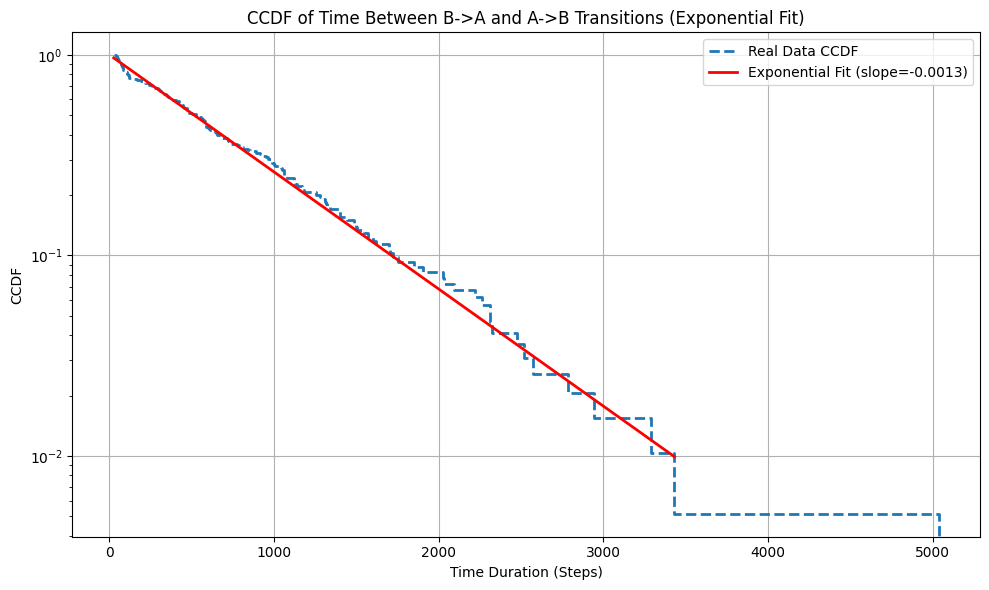

SSW Transitions A to B: 199, Mean Value: 18.12
SSW Transitions A to B: 189, Mean Value: 18.18
SSW Transitions B to A: 199, Mean Value: 7.97
SSW Transitions B to A: 189, Mean Value: 8.01
Non-SSW Transitions A: 189, Mean Value: 22.89
Non-SSW Transitions A: 189, Mean Value: 12.32
Non-SSW Transitions B: 189, Mean Value: 1.48
Non-SSW Transitions B: 189, Mean Value: 14.42
Mu shape:  torch.Size([1532, 32])
Mu values for A_ssw:  0.027890475 Mu values for B_ssw:  nan Mu values for A_noSSW:  0.0007432704 Mu values for B_noSSW:  0.012948452
Logvar shape for A_ssw:  -1.6696459 Logvar shape for B_ssw:  nan Logvar shape for A_noSSW:  -0.584659 Logvar shape for B_noSSW:  -1.7943684
Z values for A_ssw:  0.015481244 Z values for B_ssw:  nan Z values for A_noSSW:  0.009543033 Z values for B_noSSW:  -0.007447947
==>> pca: PCA(n_components=3)
==>> latent_3d: (1532, 3)
Explained variance by PC1: 0.9961
Explained variance by PC2: 0.0016
Explained variance by PC3: 0.0010
Total explained variance (PC1+2+3): 0

/home/danielboscu/Documents/code/AI_RES/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning:

Mean of empty slice.

/home/danielboscu/Documents/code/AI_RES/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning:

invalid value encountered in divide



ValueError: Trace type 'scatter3d' is not compatible with subplot type 'xy'
at grid position (1, 2)

See the docstring for the specs argument to plotly.subplots.make_subplots
for more information on subplot types

In [23]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import linregress
import seaborn as sns
import random
from sklearn.decomposition import PCA
import plotly.express as px
import pandas as pd
import matplotlib.image as mpimg

upper_bound = 53.8 / 2.8935
lower_bound = 7.41
num_neurons = 1024

model = ConditionalVAE(latent_dim, output_dim, condition_dim, num_neurons)
model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

if os.path.exists(model_weights_path):
    model.load_state_dict(torch.load(model_weights_path))
    print(f"Model weights loaded from {model_weights_path}.")

if (all_plot_flag):

    r = real_data[:300000, 1, level]
    p = predictions[:, 0, level]
    # Compute transition durations for real data
    real_durations = calculate_transition_durations(r, upper_bound, lower_bound)

    # Compute transition durations for predictions data
    pred_durations = calculate_transition_durations(p, upper_bound, lower_bound)

    # === REAL DATA CCDF AND FIT ===
    if len(real_durations) == 0:
        print("No transitions detected in real data with current bounds!")
    else:
        real_data_sorted = np.sort(real_durations)
        xlr = np.linspace(min(real_data_sorted), max(real_data_sorted), 100)
        exp_fit_r = 1/np.mean(real_data_sorted)
        yvr = exp_fit_r*xlr

    # === PREDICTIONS CCDF AND FIT ===
    if len(pred_durations) == 0:
        print("No transitions detected in predictions with current bounds!")
    else:
        pred_data_sorted = np.sort(pred_durations)
        xlp = np.linspace(min(pred_data_sorted), max(pred_data_sorted), 100)
        exp_fit_p = 1/np.mean(pred_data_sorted)
        yvp = exp_fit_p*xlp

    # Compute CCDF
    real_data_sorted = np.sort(real_durations)
    ccdf_real = 1 - np.arange(1, len(real_data_sorted) + 1) / len(real_data_sorted)

    # Filter valid data (exclude zero or negative CCDF values)
    valid_indices = ccdf_real > 0  # Avoid log(0) issues
    x_fit = real_data_sorted[valid_indices]  # Keep x in linear scale
    y_fit = np.log(ccdf_real[valid_indices])  # Apply log transformation to y

    # Perform linear regression on log-transformed data
    slope, intercept, r_value, p_value, std_err = linregress(x_fit, y_fit)

    # Convert back to exponential form (y = e^(slope*x + intercept))
    x_line = np.linspace(min(x_fit), max(x_fit), 100)
    y_line = np.exp(slope * x_line + intercept)  # Convert back from log scale

    # Plot CCDF and best-fit line
    plt.figure(figsize=(10, 6))
    plt.step(real_data_sorted, ccdf_real, where='post', label='Real Data CCDF', linewidth=2, linestyle='--')
    plt.plot(x_line, y_line, 'r-', label=f'Exponential Fit (slope={slope:.4f})', linewidth=2)

    plt.xlabel('Time Duration (Steps)')
    plt.ylabel('CCDF')
    plt.title('CCDF of Time Between B->A and A->B Transitions (Exponential Fit)')
    plt.yscale("log")  # Keep y-axis in log scale
    plt.xscale("linear")  # Keep x-axis in linear scale
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

    exp_fit_d = normalize_transition_time(exp_fit_p, 0.005, exp_fit_r)

    max_pred = np.max(pred_durations)
    min_pred = np.min(pred_durations)
    difference = abs(max_pred - min_pred)
    dur_diff_n = normalize_transition_time(difference, 10000, abs(np.max(real_durations)-np.min(real_durations)))

    rh, b = np.histogram(r, bins=100, density=True)
    ph, _ = np.histogram(p, bins=b, density=True)

    e = 1e-10
    rh += e
    ph += e

    # Calculate KL divergence between the two histograms
    kl = np.sum(rh * np.log(rh / ph))
    nkl = normalize_transition_time(kl, 1, 0)

    save_path = os.path.join(folder, "timeseries")

    # Plot 3D PCA
    def detect_transitions_A_to_B(u_series, upper, lower):
        transitions = []
        transition_values = []
        i = 0
        while i < len(u_series) - 1:
            if u_series[i-1] > upper and u_series[i] <= upper:
                j = i + 1
                while j < len(u_series) and u_series[j] <= upper:
                    if u_series[j] < lower:
                        transitions.append(i)
                        transition_values.append(u_series[i])
                        break
                    j += 1
                i = j
            else:
                i += 1
        return np.array(transitions), np.array(transition_values)

    def detect_transitions_B_to_A(u_series, upper, lower):
        transitions = []
        transition_values = []
        i = 0
        while i < len(u_series) - 1:
            if u_series[i-1] < lower and u_series[i] >= lower:
                j = i + 1
                while j < len(u_series) and u_series[j] >= lower:
                    if u_series[j] > upper:
                        transitions.append(i)
                        transition_values.append(u_series[i])
                        break
                    j += 1
                i = j
            else:
                i += 1
        return np.array(transitions), np.array(transition_values)

    ssw_indices_A1, ssw_transition_values_A1 = detect_transitions_A_to_B(real_data[:, 1, 63], upper, lower)
    ssw_indices_A0, ssw_transition_values_A0 = detect_transitions_A_to_B(real_data[:, 0, 63], upper, lower)
    ssw_indices_B1, ssw_transition_values_B1 = detect_transitions_B_to_A(real_data[:, 1, 63], upper, lower)
    ssw_indices_B0, ssw_transition_values_B0 = detect_transitions_B_to_A(real_data[:, 0, 63], upper, lower)

    AB_transitions = np.union1d(ssw_indices_A1, ssw_indices_A0)
    BA_transitions = np.union1d(ssw_indices_B1, ssw_indices_B0)
    transition_indices = np.union1d(AB_transitions, BA_transitions)
    total_len = len(real_data)
    non_ssw_indices_A1 = np.where((real_data[:, 1, 63] > upper) & (~np.isin(np.arange(total_len), transition_indices)))[0]
    non_ssw_indices_A0 = np.where((real_data[:, 0, 63] > upper) & (~np.isin(np.arange(total_len), transition_indices)))[0]
    non_ssw_indices_B1 = np.where((real_data[:, 1, 63] < lower) & (~np.isin(np.arange(total_len), transition_indices)))[0]
    non_ssw_indices_B0 = np.where((real_data[:, 0, 63] < lower) & (~np.isin(np.arange(total_len), transition_indices)))[0]

    n_samples = min(len(ssw_indices_A1), len(ssw_indices_A0), len(non_ssw_indices_A1), len(non_ssw_indices_A0))
    non_ssw_indices_A1 = np.random.choice(non_ssw_indices_A1, size=n_samples, replace=False)
    non_ssw_indices_A0 = np.random.choice(non_ssw_indices_A0, size=n_samples, replace=False)
    non_ssw_indices_B1 = np.random.choice(non_ssw_indices_B1, size=n_samples, replace=False)
    non_ssw_indices_B0 = np.random.choice(non_ssw_indices_B0, size=n_samples, replace=False)
    non_ssw_transition_values_A1 = zonal_wind[non_ssw_indices_A1]
    non_ssw_transition_values_A0 = zonal_wind[non_ssw_indices_A0]
    non_ssw_transition_values_B1 = zonal_wind[non_ssw_indices_B1]
    non_ssw_transition_values_B0 = zonal_wind[non_ssw_indices_B0]

    print(f"SSW Transitions A to B: {len(ssw_indices_A1)}, Mean Value: {np.mean(ssw_transition_values_A1):.2f}")
    print(f"SSW Transitions A to B: {len(ssw_indices_A0)}, Mean Value: {np.mean(ssw_transition_values_A0):.2f}")
    print(f"SSW Transitions B to A: {len(ssw_indices_B1)}, Mean Value: {np.mean(ssw_transition_values_B1):.2f}")
    print(f"SSW Transitions B to A: {len(ssw_indices_B0)}, Mean Value: {np.mean(ssw_transition_values_B0):.2f}")
    print(f"Non-SSW Transitions A: {len(non_ssw_indices_A1)}, Mean Value: {np.mean(non_ssw_transition_values_A1):.2f}")
    print(f"Non-SSW Transitions A: {len(non_ssw_indices_A0)}, Mean Value: {np.mean(non_ssw_transition_values_A0):.2f}")
    print(f"Non-SSW Transitions B: {len(non_ssw_indices_B1)}, Mean Value: {np.mean(non_ssw_transition_values_B1):.2f}")
    print(f"Non-SSW Transitions B: {len(non_ssw_indices_B0)}, Mean Value: {np.mean(non_ssw_transition_values_B0):.2f}")

    X = np.vstack([
        real_data[ssw_indices_A1, 1],
        real_data[ssw_indices_A0, 0],
        real_data[ssw_indices_B1, 1],
        real_data[ssw_indices_B0, 0],
        real_data[non_ssw_indices_A1, 1],
        real_data[non_ssw_indices_A0, 0],
        real_data[non_ssw_indices_B1, 1],
        real_data[non_ssw_indices_B0, 0]
    ]).astype(np.float32)

    labels = (
        ["AB"] * len(ssw_indices_A1) +
        ["AB"] * len(ssw_indices_A0) +
        ["BA"] * len(ssw_indices_B1) +
        ["BA"] * len(ssw_indices_B0) +
        ["A"] * len(non_ssw_indices_A1) +
        ["A"] * len(non_ssw_indices_A0) +
        ["B"] * len(non_ssw_indices_B1) +
        ["B"] * len(non_ssw_indices_B0)
    )

    model.eval()
    # Encode data
    with torch.no_grad():
        mu, logvar = model.encode(torch.tensor(X, dtype=torch.float32).cuda())
        z = model.reparameterize(mu, logvar)
        mu_np = mu.cpu().numpy()
        logvar_np = logvar.cpu().numpy()
        z_np = z.cpu().numpy()

    print("Mu shape: " , mu.shape)

    AB_start = 0
    AB_end = len(ssw_indices_A1) + len(ssw_indices_A0)
    BA_start = AB_end
    BA_end = AB_start + len(ssw_indices_B1) + len(ssw_indices_B0)
    A_start = BA_end
    A_end = A_start + len(non_ssw_indices_A1) + len(non_ssw_indices_A0)
    B_start = A_end
    B_end = B_start + len(non_ssw_indices_B1) + len(non_ssw_indices_B0)

    print("Mu values for A_ssw: ", np.mean(mu_np[:AB_end, :]), 
          "Mu values for B_ssw: ", np.mean(mu_np[AB_end:BA_end, :]), 
          "Mu values for A_noSSW: ", np.mean(mu_np[BA_end:A_end, :]), 
          "Mu values for B_noSSW: ", np.mean(mu_np[A_end:B_end, :]))

    print("Logvar shape for A_ssw: ", np.mean(logvar_np[:AB_end, :]), 
          "Logvar shape for B_ssw: ", np.mean(logvar_np[AB_end:BA_end, :]), 
          "Logvar shape for A_noSSW: ", np.mean(logvar_np[BA_end:A_end, :]), 
          "Logvar shape for B_noSSW: ", np.mean(logvar_np[A_end:B_end, :]))

    print("Z values for A_ssw: ", np.mean(z_np[:AB_end, :]), 
          "Z values for B_ssw: ", np.mean(z_np[AB_end:BA_end, :]), 
          "Z values for A_noSSW: ", np.mean(z_np[BA_end:A_end, :]), 
          "Z values for B_noSSW: ", np.mean(z_np[A_end:B_end, :]))

    all_plot(r, p, xlp, yvp, xlr, yvr, exp_fit_p, exp_fit_r, nkl, exp_fit_d, dur_diff_n, mu_np, labels, save_path)

if (CCDF):
    real_data_1d = real_data[:, 1, 63]  # Now shape is (309700,)
    predictions_1d = predictions[:, 0, 63]  # shape (300000,)
    
    # Function to calculate transition durations
    def calculate_transition_durations(y_values, upper_bound, lower_bound):
        times_between_transitions = []
        transition_start = None
        above_upper = False
        below_lower = False

        for i in range(1, len(y_values)):
            if y_values[i] < lower_bound:  
                below_lower = True
                above_upper = False
            elif y_values[i] > upper_bound:  
                if below_lower and transition_start is not None:
                    times_between_transitions.append(i - transition_start)
                    transition_start = None  
                above_upper = True
                below_lower = False

            if below_lower and transition_start is None:
                transition_start = i

        return times_between_transitions

    # Compute transition durations for real data
    real_durations = calculate_transition_durations(real_data_1d, upper_bound, lower_bound)

    # Compute transition durations for predictions data
    pred_durations = calculate_transition_durations(predictions_1d, upper_bound, lower_bound)

    # Plot setup
    CCDF_sum = 0
    plt.figure(figsize=(10, 6))

    def bootstrap_ci(data, num_bootstraps=1000, confidence_level=0.95):
        sample_size = len(data)
        bootstrap_means = np.zeros(num_bootstraps)
        
        for i in range(num_bootstraps):
            bootstrap_sample = np.random.choice(data, size=sample_size, replace=True)
            bootstrap_means[i] = np.mean(bootstrap_sample)
        
        ci_lower = np.percentile(bootstrap_means, (1 - confidence_level) / 2 * 100)
        ci_upper = np.percentile(bootstrap_means, (1 + confidence_level) / 2 * 100)
        
        return np.mean(data), ci_lower, ci_upper

    # === REAL DATA CCDF AND FIT ===
    if len(real_durations) == 0:
        print("No transitions detected in real data with current bounds!")
    else:
        real_data_sorted = np.sort(real_durations)
        ccdf_real = 1 - np.arange(1, len(real_data_sorted) + 1) / len(real_data_sorted)

        valid_indices_real = ccdf_real > 0
        x_fit_real = real_data_sorted[valid_indices_real]
        y_fit_real = np.log(ccdf_real[valid_indices_real])

        slope_real, intercept_real, *_ = linregress(x_fit_real, y_fit_real)

        x_line_real = np.linspace(min(x_fit_real), max(x_fit_real), 40)
        y_line_real = np.exp(slope_real * x_line_real + intercept_real)

        # Create a grid of x values (time steps / durations)

        bootstrap_mean = []
        ci_lower_vals = []
        ci_upper_vals = []

        for x in x_line_real:
            valid_indices = (real_durations > x).astype(float)
            mean_val, lower, upper = bootstrap_ci(valid_indices)
            bootstrap_mean.append(mean_val)
            ci_lower_vals.append(lower)
            ci_upper_vals.append(upper)

        bootstrap_mean = np.array(bootstrap_mean)
        ci_lower_vals = np.array(ci_lower_vals)
        ci_upper_vals = np.array(ci_upper_vals)

        # Calculate error bars (difference from the bootstrap mean)
        error_lower = bootstrap_mean - ci_lower_vals
        error_upper = ci_upper_vals - bootstrap_mean

        plt.step(real_data_sorted, ccdf_real, where='post', label='Real Data CCDF', linewidth=2, linestyle='--')
        plt.errorbar(x_line_real, bootstrap_mean, yerr=[error_lower, error_upper],
                fmt='o', color='blue', capsize=3, ecolor='blue', label='Real Bootstrap 95% CI')
        plt.plot(x_line_real, y_line_real, 'b-', label=f'Real Exp Fit (slope={slope_real:.4f})', linewidth=2)

    # === PREDICTIONS CCDF AND FIT ===
    if len(pred_durations) == 0:
        print("No transitions detected in predictions with current bounds!")
    else:
        pred_data_sorted = np.sort(pred_durations)
        ccdf_pred = 1 - np.arange(1, len(pred_data_sorted) + 1) / len(pred_data_sorted)

        valid_indices_pred = ccdf_pred > 0
        x_fit_pred = pred_data_sorted[valid_indices_pred]
        y_fit_pred = np.log(ccdf_pred[valid_indices_pred])

        slope_pred, intercept_pred, *_ = linregress(x_fit_pred, y_fit_pred)

        x_line_pred = np.linspace(min(x_fit_pred), max(x_fit_pred), 40)
        y_line_pred = np.exp(slope_pred * x_line_pred + intercept_pred)

        # Create a grid of x values (time steps / durations)

        bootstrap_mean = []
        ci_lower_vals = []
        ci_upper_vals = []

        for x in x_line_pred:
            valid_indices = (pred_durations > x).astype(float)
            mean_val, lower, upper = bootstrap_ci(valid_indices)
            bootstrap_mean.append(mean_val)
            ci_lower_vals.append(lower)
            ci_upper_vals.append(upper)

        bootstrap_mean = np.array(bootstrap_mean)
        ci_lower_vals = np.array(ci_lower_vals)
        ci_upper_vals = np.array(ci_upper_vals)

        # Calculate error bars (difference from the bootstrap mean)
        error_lower = bootstrap_mean - ci_lower_vals
        error_upper = ci_upper_vals - bootstrap_mean

        plt.step(pred_data_sorted, ccdf_pred, where='post', label='Predictions CCDF', linewidth=2, linestyle='-.', color='red')
        plt.errorbar(x_line_pred, bootstrap_mean, yerr=[error_lower, error_upper],
                fmt='o', color='red', capsize=3, ecolor='red', label='Pred Bootstrap 95% CI')
        plt.plot(x_line_pred, y_line_pred, 'r-', label=f'Pred Exp Fit (slope={slope_pred:.4f})', linewidth=2)

        CCDF_sum += slope_pred

    # Plot labels and formatting
    plt.xlabel('Time Duration (Steps)')
    plt.ylabel('CCDF')
    plt.title('CCDF of Time Between B->A and A->B Transitions (Exponential Fit)')
    plt.yscale("log")  # y-axis log scale
    plt.xscale("linear")  # x-axis linear scale
    plt.grid()
    plt.legend()
    plt.tight_layout()
    save_path = os.path.join(folder, f"CCDF_plot")
    plt.savefig(save_path)
    plt.show()
if (Bi_modal_distribution):
    zonal_wind_data_real = real_data[:, 1, 63]  # variable index 1 (e.g., zonal wind), level 60
    zonal_wind_data_predictions = predictions[:, 0, 63]  # variable index 0 (predictions), level 60

    print(f"Shape of zonal_wind_data_real: {zonal_wind_data_real.shape}")
    print(f"Shape of zonal_wind_data_predictions: {zonal_wind_data_predictions.shape}")

    # Plot the bimodal histogram
    plt.figure(figsize=(12, 6))

    # Create histograms (overlaid)
    sns.histplot(zonal_wind_data_real, bins=50, kde=True, color='black', alpha=0.6, element='step', label='Real Data')
    sns.histplot(zonal_wind_data_predictions, bins=50, kde=True, color='red', alpha=0.6, element='step', label='Predictions')

    # Customize plot labels and title
    plt.title('Distribution of Zonal Winds For Real Data and Predictions', fontsize=16)
    plt.xlabel('Zonal Wind (m/s)', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)

    # Add vertical lines at means
    plt.axvline(np.mean(zonal_wind_data_real), color='black', linestyle='--', label=f'Real Mean: {np.mean(zonal_wind_data_real):.2f}')
    plt.axvline(np.mean(zonal_wind_data_predictions), color='red', linestyle='--', label=f'Pred Mean: {np.mean(zonal_wind_data_predictions):.2f}')

    # Final plot settings
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    save_path = os.path.join(folder, "bi_modal_distribution")
    save_path = os.path.join(save_path, "bi_modal_distribution_plot")
    plt.savefig(save_path)
    plt.show()
if (single_step_profiles):
    # Ensure save directory exists
    os.makedirs(SAVE_DIR, exist_ok=True)

    # === Load model weights ===
    model.load_state_dict(torch.load(MODEL_PATH))
    model.eval()

    # === Randomly sample time points from real data ===
    time_indices = random.sample(range(0, real_data.shape[0] - 2), NUM_SAMPLES)
    print(f"Randomly sampled time steps: {time_indices}")

    # === Time series visualization ===
    real_data_timeseries = real_data[:, 1, level]
    time_steps_all = np.arange(len(real_data_timeseries))

    plt.figure(figsize=(12, 6))
    plt.plot(time_steps_all, real_data_timeseries, label="Real Data at Level 61", color='blue')

    # Mark sample points
    for idx_num, idx in enumerate(time_indices):
        plt.axvline(x=idx, color='green', linestyle='--', linewidth=2)
    if len(time_indices) > 0:
        plt.axvline(x=time_indices[0], color='green', linestyle='--', linewidth=2, label='Sampled Points')

    plt.title("Real Data Time Series with Sampled Points Highlighted")
    plt.xlabel("Time Step")
    plt.ylabel("U (m/s) at Level 61")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    save_path = os.path.join(SAVE_DIR, "real_data_timeseries_with_samples.png")
    plt.savefig(save_path)
    plt.show()

    # === Iterate over each sampled time point ===
    for i, time_step in enumerate(time_indices):
        next_time_step = time_step + 1

        # === Real data: current and next ===
        real_current = real_data[time_step, 1, :]       
        real_next = real_data[next_time_step, 1, :]      

        # === Normalize real_current and make prediction for next step ===
        initial_cond = torch.reshape(torch.tensor(psi[time_step,start:end]), [1, num_variables])
        z = torch.zeros([1,latent_dim])
        num_ens = 1
        pred = np.zeros ([time_step, num_variables, num_ens])

        with torch.no_grad():
            z = torch.randn_like(z)
            print(z.shape, initial_cond.shape)
            y = (model.decode(z.float().cuda(),initial_cond.float().cuda())).detach().cpu().numpy()

        # === Denormalize predicted next ===
        pred_next_denorm = y.squeeze() * std_psi.squeeze() + mean_psi.squeeze()

        # === Extract U, Re(Psi), Im(Psi) components ===
        # U profiles
        U_current_real = real_current[51:74]
        U_next_real = real_next[51:74]
        U_next_pred = pred_next_denorm[51:74]

        # Re(Psi) profiles
        RePsi_current_real = real_current[0:24]
        RePsi_next_real = real_next[0:24]
        RePsi_next_pred = pred_next_denorm[0:24]

        # Im(Psi) profiles
        ImPsi_current_real = real_current[25:50]
        ImPsi_next_real = real_next[25:50]
        ImPsi_next_pred = pred_next_denorm[25:50]

        # === Differences ===
        U_diff_real = U_next_real - U_current_real
        U_diff_pred = U_next_pred - U_current_real

        RePsi_diff_real = RePsi_next_real - RePsi_current_real
        RePsi_diff_pred = RePsi_next_pred - RePsi_current_real

        ImPsi_diff_real = ImPsi_next_real - ImPsi_current_real
        ImPsi_diff_pred = ImPsi_next_pred - ImPsi_current_real

        # === Create a single figure with 3 rows (U, Re(Psi), Im(Psi)) ===
        fig, axes = plt.subplots(3, 2, figsize=(16, 18))  # 3 rows, 2 columns (Profile and Difference)

        z_levels_U = np.linspace(0, 70, 23)
        z_levels_RePsi = np.linspace(0, 70, 24)
        z_levels_ImPsi = np.linspace(0, 70, 25)

        # --- U ---
        axes[0, 0].plot(U_current_real, z_levels_U, 'x-', label="Real Current")
        axes[0, 0].plot(U_next_real, z_levels_U, 'd-', label="Real Next")
        axes[0, 0].plot(U_next_pred, z_levels_U, 's--', label="Predicted Next")
        axes[0, 0].set_title(f"U Profiles @ Step {time_step}")
        axes[0, 0].set_xlabel("U (m/s)")
        axes[0, 0].set_ylabel("Vertical Levels (km)")
        axes[0, 0].legend()

        axes[0, 1].plot(U_diff_real, z_levels_U, 'xb', label="Real Δ (Next - Current)")
        axes[0, 1].plot(U_diff_pred, z_levels_U, 'o--r', label="Pred Δ (Next - Current)")
        axes[0, 1].set_title("U Difference (Next - Current)")
        axes[0, 1].set_xlabel("ΔU (m/s)")
        axes[0, 1].legend()

        # --- Re(Psi) ---
        axes[1, 0].plot(RePsi_current_real, z_levels_RePsi, 'x-', label="Real Current")
        axes[1, 0].plot(RePsi_next_real, z_levels_RePsi, 'd-', label="Real Next")
        axes[1, 0].plot(RePsi_next_pred, z_levels_RePsi, 's--', label="Predicted Next")
        axes[1, 0].set_title(f"Re(Psi) Profiles @ Step {time_step}")
        axes[1, 0].set_xlabel("Re(Psi)")
        axes[1, 0].set_ylabel("Vertical Levels (km)")
        axes[1, 0].legend()

        axes[1, 1].plot(RePsi_diff_real, z_levels_RePsi, 'xb', label="Real Δ (Next - Current)")
        axes[1, 1].plot(RePsi_diff_pred, z_levels_RePsi, 'o--r', label="Pred Δ (Next - Current)")
        axes[1, 1].set_title("Re(Psi) Difference (Next - Current)")
        axes[1, 1].set_xlabel("ΔRe(Psi)")
        axes[1, 1].legend()

        # --- Im(Psi) ---
        axes[2, 0].plot(ImPsi_current_real, z_levels_ImPsi, 'x-', label="Real Current")
        axes[2, 0].plot(ImPsi_next_real, z_levels_ImPsi, 'd-', label="Real Next")
        axes[2, 0].plot(ImPsi_next_pred, z_levels_ImPsi, 's--', label="Predicted Next")
        axes[2, 0].set_title(f"Im(Psi) Profiles @ Step {time_step}")
        axes[2, 0].set_xlabel("Im(Psi)")
        axes[2, 0].set_ylabel("Vertical Levels (km)")
        axes[2, 0].legend()

        axes[2, 1].plot(ImPsi_diff_real, z_levels_ImPsi, 'xb', label="Real Δ (Next - Current)")
        axes[2, 1].plot(ImPsi_diff_pred, z_levels_ImPsi, 'o--r', label="Pred Δ (Next - Current)")
        axes[2, 1].set_title("Im(Psi) Difference (Next - Current)")
        axes[2, 1].set_xlabel("ΔIm(Psi)")
        axes[2, 1].legend()

        # === Finalize and Save ===
        plt.suptitle(f"Single Step Profile Comparisons at Time Step {time_step}", fontsize=18)
        plt.tight_layout(rect=[0, 0.03, 1, 0.97])

        save_path = os.path.join(SAVE_DIR, f"Profile_Summary_point_{time_step}.png")
        plt.savefig(save_path)
        plt.show()

        print(f"Combined plot saved for sampled point {time_step}")

    # Final debug
    print("Finished processing all sampled points.")
        # Debugging prints
    print(predictions.shape) 
    print(real_data.shape)